In [1]:
import os
import pandas as pd

path = "Tweets.csv"   # change if you saved it with a different name/path
print("exists?", os.path.exists(path))
print("size (MB):", os.path.getsize(path) / (1024*1024))

# load only the columns we need (saves memory)
usecols = ['text','airline_sentiment']   # if those column names differ, we'll adjust below
df = pd.read_csv(path, usecols=usecols)
print("rows, cols:", df.shape)
df.head()


exists? True
size (MB): 3.2629308700561523
rows, cols: (14640, 2)


,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [4]:
# Run this single cell to reliably produce df['clean_text']
import os, sys, re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Ensure we have an explicit local nltk data folder (avoid permission issues)
local_nltk_dir = os.path.join(os.getcwd(), "nltk_data")
if local_nltk_dir not in nltk.data.path:
    nltk.data.path.insert(0, local_nltk_dir)

needed = ["punkt", "stopwords", "wordnet", "omw-1.4"]
missing = []
for pkg in needed:
    try:
        nltk.data.find(pkg)
    except LookupError:
        missing.append(pkg)

if missing:
    print("Downloading missing NLTK packages to", local_nltk_dir, ":", missing)
    for pkg in missing:
        nltk.download(pkg, download_dir=local_nltk_dir, quiet=False)
else:
    print("NLTK packages already present.")

# Build fallback-safe preprocess: try proper tokenizer, else a simple split
try:
    # test tokenizer
    _ = word_tokenize("test sentence")
    USE_NLTK = True
except Exception as e:
    print("NLTK tokenizer not available, will use fallback tokenization. Error:", e)
    USE_NLTK = False

# Prepare stopwords/lemmatizer if available; else small fallback stoplist
try:
    stop_words = set(stopwords.words("english"))
except Exception:
    stop_words = {"the","and","a","an","is","it","to","for","of","in","on","this","that","i","you","we","they","me","my"}

try:
    lemmatizer = WordNetLemmatizer()
except Exception:
    lemmatizer = None

def clean_text_basic(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www.\S+', ' ', text)
    text = re.sub(r'@\w+', ' ', text)
    text = re.sub(r'#', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_and_process(text):
    ct = clean_text_basic(text)
    if USE_NLTK:
        toks = word_tokenize(ct)
    else:
        toks = ct.split()
    toks = [t for t in toks if t not in stop_words and len(t) > 1]
    if lemmatizer is not None:
        try:
            toks = [lemmatizer.lemmatize(t) for t in toks]
        except Exception:
            pass
    return " ".join(toks)

# Apply to df safely and show progress
print("Applying preprocessing to df['text'] (this may take ~20-60s depending on size)...")
df['clean_text'] = df['text'].apply(tokenize_and_process)
print("Done. Preview:")
display(df.head())
print("Sample cleaned text (first 5):")
for i, s in enumerate(df['clean_text'].head(5)):
    print(i, ":", s[:200])


[nltk_data] Downloading package punkt to c:\Users\Saurabh\Desktop\NLP
[nltk_data]     project\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     c:\Users\Saurabh\Desktop\NLP project\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     c:\Users\Saurabh\Desktop\NLP project\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     c:\Users\Saurabh\Desktop\NLP project\nltk_data...


NLTK tokenizer not available, will use fallback tokenization. Error: 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - 'c:\\Users\\Saurabh\\Desktop\\NLP project\\nltk_data'
    - 'C:\\Users\\Saurabh/nltk_data'
    - 'c:\\Users\\Saurabh\\anaconda3\\nltk_data'
    - 'c:\\Users\\Saurabh\\anaconda3\\share\\nltk_data'
    - 'c:\\Users\\Saurabh\\anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Saurabh\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************

Applying preprocessing to df['text'] (this may take ~20-60s depending on size)...
Done. Preview:


,airline_sentiment,text,clean_text
0,neutral,@VirginAmerica What @dhepburn said.,said
1,positive,@VirginAmerica plus you've added commercials t...,plus added commercial experience tacky
2,neutral,@VirginAmerica I didn't today... Must mean I n...,today must mean need take another trip
3,negative,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...
4,negative,@VirginAmerica and it's a really big bad thing...,really big bad thing


Sample cleaned text (first 5):
0 : said
1 : plus added commercial experience tacky
2 : today must mean need take another trip
3 : really aggressive blast obnoxious entertainment guest face amp little recourse
4 : really big bad thing


In [5]:
# 🧩 Step 3 — Vectorize the text and split train/test
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Separate features (X) and labels (y)
X = df['clean_text']
y = df['airline_sentiment']

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

# Convert text to numeric vectors using TF-IDF
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2))  # 3000 features = light on RAM
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

print("Vectorization complete. Shape:", X_train_vec.shape)


Training samples: 11712
Testing samples: 2928
Vectorization complete. Shape: (11712, 3000)


In [6]:
# Cell: train three models (LogisticRegression, LinearSVC, MultinomialNB)
# Train three baseline classifiers and evaluate on test set
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    "LinearSVC": LinearSVC(max_iter=10000, random_state=42),
    "MultinomialNB": MultinomialNB()
}

fitted = {}
for name, model in models.items():
    print(f"\nTraining {name} ...")
    model.fit(X_train_vec, y_train)
    fitted[name] = model
    preds = model.predict(X_test_vec)
    acc = accuracy_score(y_test, preds)
    print(f"{name} Test Accuracy: {acc:.4f}")
    print(classification_report(y_test, preds))



Training LogisticRegression ...
LogisticRegression Test Accuracy: 0.7824
              precision    recall  f1-score   support

    negative       0.81      0.93      0.87      1835
     neutral       0.65      0.50      0.57       620
    positive       0.82      0.57      0.67       473

    accuracy                           0.78      2928
   macro avg       0.76      0.67      0.70      2928
weighted avg       0.78      0.78      0.77      2928


Training LinearSVC ...
LinearSVC Test Accuracy: 0.7777
              precision    recall  f1-score   support

    negative       0.84      0.89      0.86      1835
     neutral       0.60      0.56      0.58       620
    positive       0.74      0.62      0.68       473

    accuracy                           0.78      2928
   macro avg       0.73      0.69      0.71      2928
weighted avg       0.77      0.78      0.77      2928


Training MultinomialNB ...
MultinomialNB Test Accuracy: 0.7432
              precision    recall  f1-score 

Best model: LogisticRegression with accuracy 0.7824453551912568


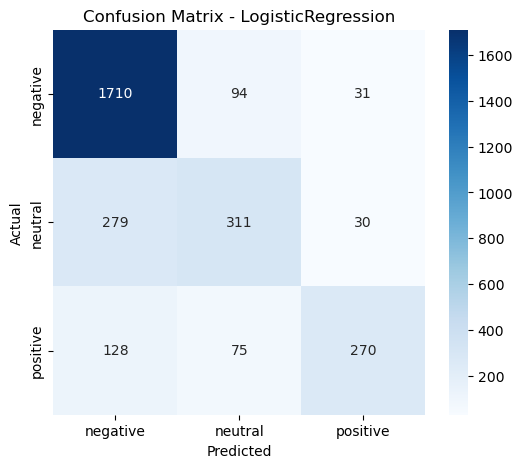

In [7]:
# Cell: pick best model, show confusion matrix and save evaluation
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import confusion_matrix

# choose best by accuracy on test
best_name, best_model = None, None
best_acc = -1.0
for name, model in fitted.items():
    preds = model.predict(X_test_vec)
    acc = accuracy_score(y_test, preds)
    if acc > best_acc:
        best_acc = acc
        best_name = name
        best_model = model

print("Best model:", best_name, "with accuracy", best_acc)

# Confusion matrix
y_pred_best = best_model.predict(X_test_vec)
cm = confusion_matrix(y_test, y_pred_best, labels=np.unique(y))
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - {best_name}")
plt.show()


In [8]:
# Cell: show top features per class (for LogisticRegression only)
# Show top features if model exposes coef_ (LogisticRegression or LinearSVC)
def show_top_features(model, vectorizer, label_names, top_n=15):
    if not hasattr(model, "coef_"):
        print("Model has no coef_. Can't show top features.")
        return
    feature_names = vectorizer.get_feature_names_out()
    coefs = model.coef_
    # If multiclass: one row per class
    for i, label in enumerate(label_names):
        top_idx = np.argsort(coefs[i])[-top_n:][::-1]
        top_features = [feature_names[j] for j in top_idx]
        print(f"\nTop {top_n} features for class '{label}':")
        print(", ".join(top_features))

# label names in sorted order of unique labels
label_names = sorted(df['airline_sentiment'].unique())
show_top_features(best_model if hasattr(best_model, 'coef_') else fitted['LogisticRegression'], tfidf, label_names, top_n=12)



Top 12 features for class 'negative':
hour, worst, delayed, hold, hr, bag, nothing, luggage, delay, cancelled, customer, ridiculous

Top 12 features for class 'neutral':
hi, chance, flyingitforward, avgeek, journal, ceo, march, possible, delay cancelled, winner, atlanta, vega

Top 12 features for class 'positive':
great, thanks, thank, awesome, love, best, amazing, appreciate, thx, excellent, kudos, wonderful


In [11]:
!pip install wordcloud pillow


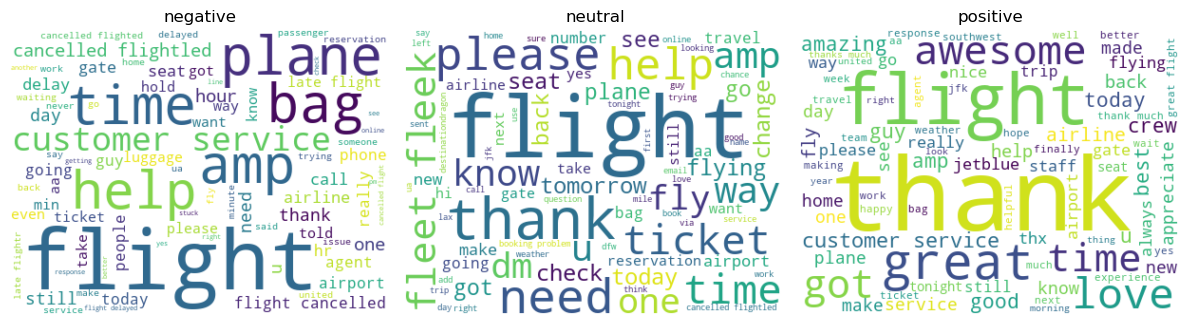

In [ ]:
# Cell: WordClouds for each sentiment (visual)
# Wordclouds — install pillow/wordcloud if you haven't: pip install wordcloud pillow
from wordcloud import WordCloud

sent_text = {}
for cls in df['airline_sentiment'].unique():
    joined = " ".join(df.loc[df['airline_sentiment']==cls, 'clean_text'].astype(str).tolist())
    sent_text[cls] = joined

plt.figure(figsize=(12,5))
for i, cls in enumerate(sorted(sent_text.keys())):
    plt.subplot(1, len(sent_text.keys()), i+1)
    wc = WordCloud(width=400, height=300, background_color='white', max_words=80).generate(sent_text[cls])
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(cls)
plt.tight_layout()
plt.show()

In [13]:
# Cell: Save the best model and vectorizer (joblib)
# Save best model and tfidf vectorizer to disk for later use
import os
os.makedirs("models", exist_ok=True)
joblib.dump(best_model, "models/best_model.joblib")
joblib.dump(tfidf, "models/tfidf_vectorizer.joblib")
print("Saved best model and vectorizer to ./models/")


Saved best model and vectorizer to ./models/


In [14]:
# Cell: helper function to predict a single tweet (preprocess + vectorize + predict)
# Re-use the earlier cleaning/tokenize functions (we assume they exist in the notebook).
# If not, re-declare 'clean_text_basic' and 'tokenize_and_process' or use the simpler preprocess_simple.

def predict_single(text, model=best_model, vectorizer=tfidf):
    # Use same preprocessing pipeline as earlier
    try:
        cleaned = tokenize_and_process(text)
    except NameError:
        # fallback: minimal cleaning if helper absent
        import re
        cleaned = re.sub(r'http\S+|www.\S+|@\w+|[^a-zA-Z\s]',' ', str(text).lower())
        cleaned = " ".join([t for t in cleaned.split() if len(t)>1])
    vec = vectorizer.transform([cleaned])
    pred = model.predict(vec)[0]
    return pred

# Quick demo predictions
samples = [
    "I love the new seats and the friendly staff!",
    "My luggage was lost and customer service was useless.",
    "Flight was okay, nothing special."
]
for s in samples:
    print(s, "->", predict_single(s))


I love the new seats and the friendly staff! -> positive
My luggage was lost and customer service was useless. -> negative
Flight was okay, nothing special. -> negative


In [15]:
# Cell: (Optional) Evaluate model probabilities & show examples of mistakes
# Show some misclassified examples for manual inspection
y_pred = best_model.predict(X_test_vec)
mis_idx = [i for i,(a,b) in enumerate(zip(y_test, y_pred)) if a!=b]
print("Number of misclassified examples:", len(mis_idx))

# show up to 10 misclassifications
for i in mis_idx[:10]:
    print("\n--- Example ---")
    print("TEXT:", X_test.iloc[i])
    print("TRUE :", y_test.iloc[i])
    print("PRED :", y_pred[i])
    # show probabilities if model supports predict_proba
    if hasattr(best_model, "predict_proba"):
        print("PROBS:", best_model.predict_proba(X_test_vec[i]))


Number of misclassified examples: 637

--- Example ---
TEXT: past
TRUE : neutral
PRED : negative
PROBS: [[0.73317053 0.18826177 0.0785677 ]]

--- Example ---
TEXT: would say delay likely thanks much
TRUE : positive
PRED : negative
PROBS: [[0.47428917 0.22641985 0.29929098]]

--- Example ---
TEXT: link tweet go someone internal email gt probably one rd party contract
TRUE : neutral
PRED : negative
PROBS: [[0.67263062 0.27667177 0.05069761]]

--- Example ---
TEXT: flight resume see open schedule
TRUE : negative
PRED : neutral
PROBS: [[0.2820681  0.64778971 0.07014219]]

--- Example ---
TEXT: well miss gate agent rebooked boarding pas waiting landed time lunch amp beverage easy cheesy
TRUE : positive
PRED : negative
PROBS: [[0.85453541 0.03572309 0.1097415 ]]

--- Example ---
TEXT: site gmail facebook etc
TRUE : neutral
PRED : negative
PROBS: [[0.58341305 0.33276754 0.08381941]]

--- Example ---
TEXT: bummer understand business deal thanks answering much less sad
TRUE : neutral
PRED : neg